# Product Recognition on Store Shelves
Project for Computer Vision And Image Processing exam, Matteo Giri (matteo.giri@studio.unibo.it)

## Step A - Multiple Product Detection
To solve this step, I used an object detection pipeline in OpenCV using the paradigm of **Local Invariant Features**. Specifically, I used **SIFT** for detecting and describing the keypoints of the images, a knn-search algorithm of the **Flann-based matcher** for feature matching, and the **RANSAC** algorithm to find a robust homography that allows obtaining the position of the objects found in the scene.

### 1- Preliminary operations

In [1]:
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt

#list of colors for found products
colors = [(255,0,0),(0,255,0),(0,0,255), (220,0,255),(255,255,0),(0,128,255),(0,255,255),(255,128,0),(255,0,128),(255,100,255),(255,255,255),(0,0,0),(128,128,128),(128,0,0),(0,128,0),(0,0,128), (220,0,128),(128,128,0),(0,128,128),(0,128,255),(255,56,0),(128,0,56),(255,153,255),(56,56,56),(128,0,56),(100,80,70),(100,0,200),(0,255,0),(0,0,255), (220,0,255),(255,255,0),(0,128,255),(0,255,255),(255,128,0),(255,0,128),(255,100,255),(255,255,255),(0,0,0),(128,128,128)]

### 2- Loading of query and test images
Since the query images are of different sizes, they are all resized to 250x180px so that they all have the same dimensions and avoid inconsistencies in the detection of keypoints.

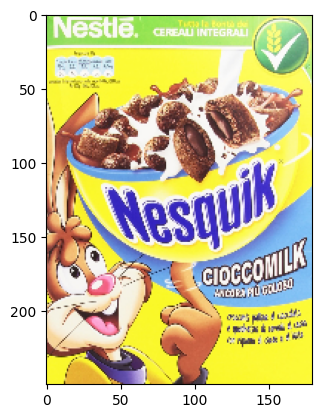

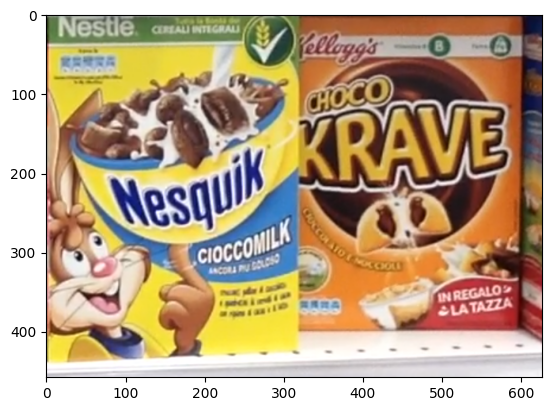

In [2]:
#Load model images
queries = ['0','1','11','19','24','25','26']
img_queries = []
for query in queries:
    img_queries.append(cv2.imread('object_detection_project/models/'+ query + '.jpg'))

for i in range(len(img_queries)):
    img_queries[i] = cv2.resize(img_queries[i],(180,250))
    
plt.imshow(cv2.cvtColor(img_queries[0], cv2.COLOR_BGR2RGB))
plt.show()

#Load scene images
trains = ['e1','e2','e3','e4','e5']
img_trains = []
for train in trains:
    img_trains.append(cv2.imread('object_detection_project/scenes/' + train + '.png'))

plt.imshow(cv2.cvtColor(img_trains[0], cv2.COLOR_BGR2RGB))
plt.show()

### 3- Keypoints detection and description
The function *get_kp_and_des* takes an image and the number of color channels of the image as input and returns two lists containing the detected keypoints and their corresponding descriptors. The two returned lists are divided by the color channels of the image, so that matching can be performed separately for each channel and obtain a more robust result.

In [3]:
def get_kp_and_des(img, channels=3):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = []
    des = []
    for i in range(channels): #for each color channel of the image
        channel = img[:,:,i]
        kp_c = sift.detect(channel)
        kp_c, des_c = sift.compute(channel,kp_c)
        kp.append(kp_c)
        des.append(des_c)
    return kp,des

### 4- Feature matching
The function *match_descriptors* takes as input the lists containing the descriptors of a query image and a train image, and returns the list containing the matches found by the Flann-Based Matcher divided by color channel. Before being returned, the matches found by the matcher are filtered through the **Lowe's Ratio Test**, which allows discarding incorrect matches by assuming that a match for a keypoint is good if the distance it has with the second best match for that keypoint is greater than a certain value.

In [4]:
def match_descriptors(des_query,des_train, channels=3):
    good = []
    for i in range(channels): #for each color channel of the image
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_query[i],des_train[i],k=2)

        # Filtering false matches
        good_c = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good_c.append(m)
        good.append(good_c)
    return good

### 5- Homography calculation
The function *calculate_homography* takes as input the keypoints found in the query and train images and the matches obtained with the *match_descriptors* function, and returns the homography calculated using the *findHomography* function of OpenCV (which uses RANSAC to obtain a robust homography). In this phase, the matches from various color channels are combined.

In [5]:
def calculate_homography(kp_query,kp_train,good,channels=3):
    good_src = np.array([])
    good_dst = np.array([])
    for i in range(channels):
        src_pts = np.float32([ kp_query[i][m.queryIdx].pt for m in good[i] ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[i][m.trainIdx].pt for m in good[i] ]).reshape(-1,1,2)

        good_src = np.vstack([good_src,src_pts]) if good_src.size else src_pts
        good_dst = np.vstack([good_dst,dst_pts]) if good_dst.size else dst_pts

    M, _ = cv2.findHomography(good_src, good_dst, cv2.RANSAC, 5.0)
    return M

### 6- Utility functions
The function *capproximate_rectangle* allows approximating the bounding box of the detected object with a rectangle, in order to obtain its center and dimensions (width, height). The function takes as input the points defining the bounding box of the detected object (obtained by applying the calculated homography) and returns the points defining the approximate rectangle, its dimensions, and its center.

The function *two_point_distance* returns the Euclidean distance between two points, used to calculate the dimensions of the rectangle.

In [8]:
def approximate_rectangle(points,img_dim):
    top_left = points[0][0]
    bottom_left = points[1][0]
    bottom_right = points[2][0]
    top_right = points[3][0]
    
    top_y = round((top_left[1] + top_right[1])/2)
    bottom_y = round((bottom_left[1] + bottom_right[1])/2)
    left_x = round((top_left[0]+bottom_left[0])/2)
    right_x = round((top_right[0]+bottom_right[0])/2)
    
    #create rectangle and calculate width, height and center
    rectangle = np.array(([[left_x,top_y]],[[left_x,bottom_y]],[[right_x,bottom_y]],[[right_x,top_y]]))    
    width = round(two_points_distance(rectangle[3][0],rectangle[0][0]))
    height = round(two_points_distance(rectangle[1][0],rectangle[0][0]))
    center = np.array([round((left_x+right_x)/2),round((top_y+bottom_y)/2)])
    
    #only for visualization, crop the rectangle to be rendered inside the scene 
    #top_y = top_y if top_y>0 else 0
    #bottom_y = bottom_y if bottom_y<img_dim[0] else img_dim[0]
    #left_x = left_x if left_x>0 else 0
    #right_x = right_x if right_x < img_dim[1] else img_dim[1]
    #rectangle = np.array(([[left_x,top_y]],[[left_x,bottom_y]],[[right_x,bottom_y]],[[right_x,top_y]]))
    return rectangle,width,height,center
    
    
def two_points_distance(A, B):
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

### 7- Complete pipeline
Below is the entire object detection pipeline applied:

For each train image, keypoints and descriptors of the image are calculated. For each query image, keypoints and descriptors are calculated and matched with the descriptors of the train image. The found matches are considered for the calculation of the homography only if they exceed a certain threshold MIN_MATCH_COUNT (below which the object is considered not found in the scene). After calculating the homography, the transformation that takes us from points in the query image to points in the train image is applied, the bounding box rectangle is approximated, and the information of the detected object is saved in a list. Finally, for each train image, the bounding boxes of the found objects are drawn, and various information is printed.

Product 0 - 1 instance(s) found:
     Instance 1 {position: (162,214), width: 309px, height: 431px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
     Instance 1 {position: (444,168), width: 299px, height: 391px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:


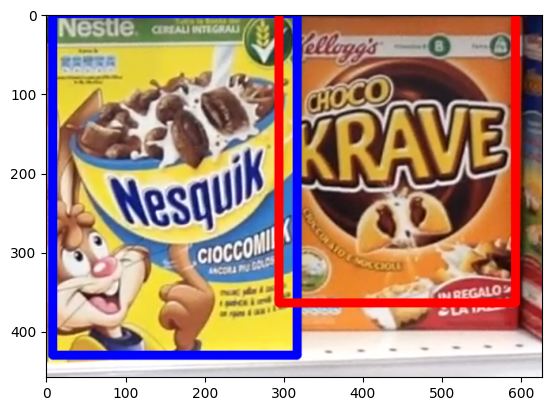

-------------------------------------------------------------------------------------------------
Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 1 instance(s) found:
     Instance 1 {position: (167,219), width: 334px, height: 488px}
Product 25 - 1 instance(s) found:
     Instance 1 {position: (879,230), width: 310px, height: 437px}
Product 26 - 1 instance(s) found:
     Instance 1 {position: (538,218), width: 332px, height: 486px}


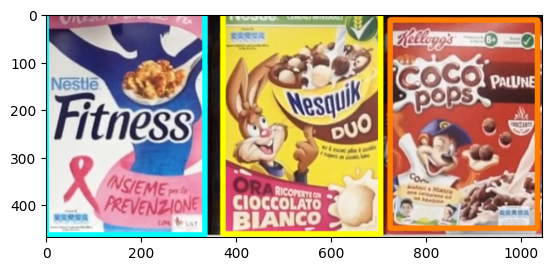

-------------------------------------------------------------------------------------------------
Product 0 - 1 instance(s) found:
     Instance 1 {position: (170,236), width: 323px, height: 438px}
Product 1 - 1 instance(s) found:
     Instance 1 {position: (818,190), width: 303px, height: 404px}
Product 11 - 1 instance(s) found:
     Instance 1 {position: (476,188), width: 303px, height: 397px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:


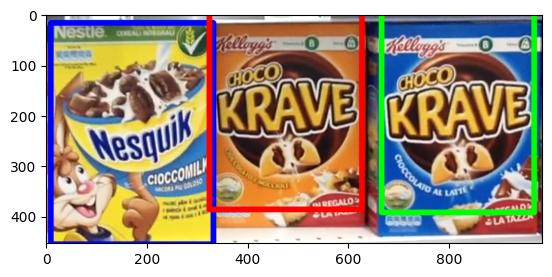

-------------------------------------------------------------------------------------------------
Product 0 - 1 instance(s) found:
     Instance 1 {position: (158,739), width: 323px, height: 438px}
Product 1 - 0 instance(s) found:
Product 11 - 1 instance(s) found:
     Instance 1 {position: (464,689), width: 303px, height: 396px}
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
     Instance 1 {position: (556,210), width: 323px, height: 450px}
Product 26 - 1 instance(s) found:
     Instance 1 {position: (206,196), width: 341px, height: 493px}


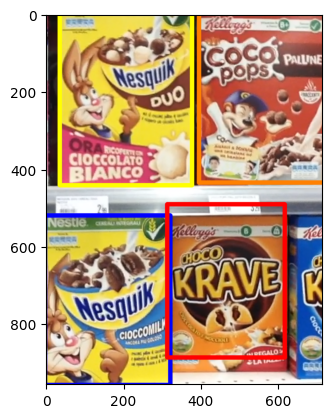

-------------------------------------------------------------------------------------------------
Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 1 instance(s) found:
     Instance 1 {position: (504,190), width: 295px, height: 384px}
Product 24 - 0 instance(s) found:
Product 25 - 1 instance(s) found:
     Instance 1 {position: (160,228), width: 319px, height: 443px}
Product 26 - 0 instance(s) found:


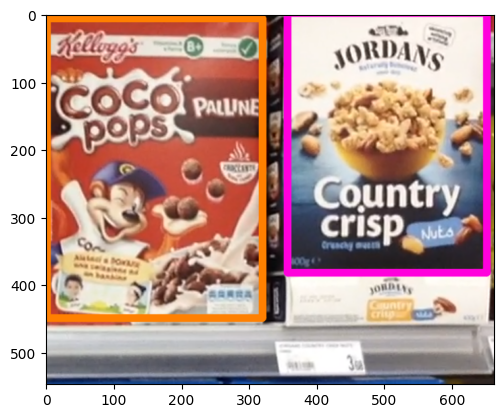

-------------------------------------------------------------------------------------------------


In [9]:
MIN_MATCH_COUNT = 240 #threshold for the number of matches to be considered for the homography calculation

for img_train in img_trains:
    img_train_c = img_train.copy()
    kp_train, des_train = get_kp_and_des(img_train)
    instances_info = []
    
    
    for img_query in img_queries:       
        instances_info_query = []
        
        kp_query, des_query = get_kp_and_des(img_query)
        good = match_descriptors(des_query,des_train)
       
        if len(good[0]) + len(good[1]) + len(good[2])>MIN_MATCH_COUNT:
            M = calculate_homography(kp_query,kp_train,good)
            # Corners of the query image
            h,w,_ = img_query.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

            # Projecting the corners into the train image
            dst = cv2.perspectiveTransform(pts,M)
            
            dst,box_width,box_height,box_center= approximate_rectangle(dst,img_train[:,:,0].shape)
            instance_info = (box_width,box_height,box_center,dst)
            instances_info_query.append(instance_info)
        instances_info.append(instances_info_query)

    
    
    #draw found instances and print information
    for instances_info_query,color,name in zip(instances_info,colors,queries):
        inst_num = 0
        found_instances = len(instances_info_query)
        print("Product {} - {} instance(s) found:".format(name,found_instances))
        for instance_info in instances_info_query: 
            # Drawing the bounding box
            img_train_c = cv2.polylines(img_train_c,[np.int32(instance_info[3])],True,color,10, cv2.LINE_AA)
            # printing information
            box_width = instance_info[0]
            box_height = instance_info[1]
            box_center = instance_info[2]
            inst_num +=1
            print("     Instance {} {{position: ({},{}), width: {}px, height: {}px}}".format(inst_num,box_center[0],box_center[1],box_width,box_height))
   
    plt.imshow(cv2.cvtColor(img_train_c, cv2.COLOR_BGR2RGB))
    plt.show()
    print("-------------------------------------------------------------------------------------------------")

### 8- Conclusions
As can be seen from the result, the applied object detection pipeline successfully manages to correctly identify all the different products in the various tested images.